# LIME Explanation for Hypertension Detection
In this notebook, we will walk through interpreting a machine learning problem (predicting the risk of developing hypertension) using records of the Cardiorespiratory Fitness dataset from the Henry Ford Testing (FIT) Project.

In [1]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.mode.chained_assignment = None

## Reading the Dataset

In [2]:
df = pd.read_csv('HTN.csv')
df.head()

,studycode,age,sex,bmi,mets_achieved,mets_c,resting_heart_rt,resting_systolic,resting_diastolic,peak_heart_rt,...,aflutter2,warfarin2,obesity2,sedentary2,htnresponse,black,Model from logisitc regression,Framingham risk,CVDrisk,newHTN
0,3,36.399727,Male,NaN,10.1,3,43,120,76,138,...,0,0,0,0,0,0,0.149920,0.027146,0.006353,0
1,6,77.314171,Female,NaN,1.8,1,73,118,70,128,...,0,0,0,0,0,1,0.593590,0.026011,0.183642,1
2,7,89.629021,Male,NaN,7.0,2,79,130,70,135,...,0,0,0,0,0,1,0.692585,0.455537,0.223481,0
3,9,46.885696,Female,NaN,12.9,4,78,136,96,168,...,0,0,0,0,0,0,0.377957,0.062413,0.018597,1
4,13,78.253250,Male,NaN,3.2,1,88,140,80,131,...,0,0,0,0,0,0,0.638435,0.525829,0.389451,0


## Data Preprocessing
### Handling Missing Values

In [3]:
null_idx = df[df['peak_diastolic'].isnull()].index.tolist()

In [4]:
df['peak_diastolic'][df['peak_diastolic'].isnull()] = df['peak_diastolic'].mean()

In [5]:
df.iloc[null_idx[0]]

studycode                               1246
age                                  69.3744
sex                                     Male
bmi                                      NaN
mets_achieved                           10.1
mets_c                                     3
resting_heart_rt                          77
resting_systolic                         120
resting_diastolic                         80
peak_heart_rt                            155
peak_systolic                            190
peak_diastolic                       81.8557
percent_hr_achieved                  1.02649
adequatestudy85                            1
0rm_rest_ekg_flg                           1
reason                            Arrhythmia
aspirin                                    0
statin                                     0
other_lipid                                0
all_lipid                                  0
insulin                                    0
dmmed                                      0
depression

### Outliers

In [6]:
df_q1 = df.quantile(q=0.25)
df_q3 = df.quantile(q=0.75)
df_iqr = df_q3 - df_q1

In [7]:
numeric_cols = ['age', 'mets_achieved', 'resting_systolic', 'resting_diastolic',
       'peak_diastolic', 'hyperlipid', 'percent_hr_achieved']
for col_name in numeric_cols:
    col_mask = (df[col_name] >= (df_q1[col_name] - (1.5 * df_iqr[col_name]))) & (df[col_name] <= (df_q3[col_name] + (1.5 * df_iqr[col_name])))
    df[col_name] = df[col_name][col_mask]

In [8]:
# Select used columns only (features and target)
df_all = df[["age","mets_achieved","resting_systolic","resting_diastolic","peak_diastolic","reason","htnresponse","k0wncad","dm","aspirin","hyperlipid","black","percent_hr_achieved","newHTN"]]

In [9]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23095 entries, 0 to 23094
Data columns (total 14 columns):
age                    22925 non-null float64
mets_achieved          23095 non-null float64
resting_systolic       22789 non-null float64
resting_diastolic      22969 non-null float64
peak_diastolic         22827 non-null float64
reason                 23095 non-null object
htnresponse            23095 non-null int64
k0wncad                23095 non-null int64
dm                     23095 non-null int64
aspirin                23095 non-null int64
hyperlipid             23095 non-null int64
black                  23095 non-null int64
percent_hr_achieved    22233 non-null float64
newHTN                 23095 non-null int64
dtypes: float64(6), int64(7), object(1)
memory usage: 2.5+ MB


In [10]:
df_all.dropna(inplace=True)

In [11]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21515 entries, 1 to 23094
Data columns (total 14 columns):
age                    21515 non-null float64
mets_achieved          21515 non-null float64
resting_systolic       21515 non-null float64
resting_diastolic      21515 non-null float64
peak_diastolic         21515 non-null float64
reason                 21515 non-null object
htnresponse            21515 non-null int64
k0wncad                21515 non-null int64
dm                     21515 non-null int64
aspirin                21515 non-null int64
hyperlipid             21515 non-null int64
black                  21515 non-null int64
percent_hr_achieved    21515 non-null float64
newHTN                 21515 non-null int64
dtypes: float64(6), int64(7), object(1)
memory usage: 2.5+ MB


** Note: number of records after removing outliers = 21515 **

### Discretization

In [12]:
disc_cols = ["age","mets_achieved","resting_systolic","resting_diastolic","peak_diastolic","percent_hr_achieved"]
quantile_labels = [1, 2, 3, 4]
quantile_list = [0, .25, .5, .75, 1.]

In [13]:
for col_name in disc_cols:
    df_all[col_name] = pd.qcut(df_all[col_name], labels= quantile_labels, q=quantile_list)

In [14]:
df_all.head()

,age,mets_achieved,resting_systolic,resting_diastolic,peak_diastolic,reason,htnresponse,k0wncad,dm,aspirin,hyperlipid,black,percent_hr_achieved,newHTN
1,4,1,2,1,3,Chest Pain,0,0,0,0,0,1,2,1
3,2,3,4,4,2,Chest Pain,0,0,0,0,1,0,3,1
4,4,1,4,2,1,Ab0rmal Test,0,0,0,0,1,0,2,0
5,2,3,1,1,1,Chest Pain,0,0,0,0,0,1,3,0
6,3,2,2,3,2,Rule out Ischemia,0,0,0,0,0,0,4,1


### Extract Used Features

In [15]:
df_feats = df_all[["age","mets_achieved","resting_systolic","resting_diastolic","peak_diastolic","reason","htnresponse","k0wncad","dm","aspirin","hyperlipid","black","percent_hr_achieved"]]
df_target = df_all[["newHTN"]]

In [16]:
df_feats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21515 entries, 1 to 23094
Data columns (total 13 columns):
age                    21515 non-null category
mets_achieved          21515 non-null category
resting_systolic       21515 non-null category
resting_diastolic      21515 non-null category
peak_diastolic         21515 non-null category
reason                 21515 non-null object
htnresponse            21515 non-null int64
k0wncad                21515 non-null int64
dm                     21515 non-null int64
aspirin                21515 non-null int64
hyperlipid             21515 non-null int64
black                  21515 non-null int64
percent_hr_achieved    21515 non-null category
dtypes: category(6), int64(6), object(1)
memory usage: 1.4+ MB


### Generate a label encoding scheme for the 'reason' attribute

In [17]:
df_feats.reason.unique()

array(['Chest Pain', 'Ab0rmal Test', 'Rule out Ischemia', 'K0wn CAD',
       'Pre-Operation', 'Shortness of Breath', 'Other', 'Arrhythmia',
       'Palpitation', 'Screening, Research', 'Dizzy, Fatigue',
       'Risk Factor', 'Conduction System Disease'], dtype=object)

In [18]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
reason_labels = le.fit_transform(df_feats['reason'])
reason_mappings = {index: label for index, label in enumerate(le.classes_)}
reason_mappings

{0: 'Ab0rmal Test',
 1: 'Arrhythmia',
 2: 'Chest Pain',
 3: 'Conduction System Disease',
 4: 'Dizzy, Fatigue',
 5: 'K0wn CAD',
 6: 'Other',
 7: 'Palpitation',
 8: 'Pre-Operation',
 9: 'Risk Factor',
 10: 'Rule out Ischemia',
 11: 'Screening, Research',
 12: 'Shortness of Breath'}

In [19]:
df_feats['reason'] = reason_labels

In [20]:
df_feats.head()

,age,mets_achieved,resting_systolic,resting_diastolic,peak_diastolic,reason,htnresponse,k0wncad,dm,aspirin,hyperlipid,black,percent_hr_achieved
1,4,1,2,1,3,2,0,0,0,0,0,1,2
3,2,3,4,4,2,2,0,0,0,0,1,0,3
4,4,1,4,2,1,0,0,0,0,0,1,0,2
5,2,3,1,1,1,2,0,0,0,0,0,1,3
6,3,2,2,3,2,10,0,0,0,0,0,0,4


### Handling class imbalance with SMOTE

In [21]:
df_target.newHTN.sum()

7302

Number of positive class instances = 7302, and negative class instances = 14213

In [22]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE 

X, y = df_feats, df_target
print('Original dataset shape {}'.format(Counter(y['newHTN'])))
sm = SMOTE(random_state=42)

X_res, y_res = sm.fit_sample(X, y)
X_resampled = pd.DataFrame(X_res)
X_resampled.columns = X.columns
y_resampled = pd.DataFrame(y_res)
y_resampled.columns = y.columns

print('Resampled dataset shape {}'.format(Counter(y_res)))

Original dataset shape Counter({0: 14213, 1: 7302})


C:\Users\Sara\Anaconda3\envs\nano\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Resampled dataset shape Counter({1: 14213, 0: 14213})


In [23]:
# recover labels for categorical attributes after resampling
X_resampled = X_resampled.round()

## Train-Test Split

In [24]:
from sklearn.model_selection import train_test_split

# Split into 70% training and 30% testing set
X, X_test, y, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.3, random_state = 42)

print(X.shape)
print(X_test.shape)
print(y.shape)
print(y_test.shape)

(19898, 13)
(8528, 13)
(19898, 1)
(8528, 1)


## Baseline model

In [25]:
# Calculate mean absolute error
def mean_abs_error(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

In [26]:
baseline_guess = np.mean(y)

print('The baseline guess is a score of %0.2f' % baseline_guess)
print("Baseline Performance on the test set: MAE = %0.4f" % mean_abs_error(y_test, baseline_guess))

The baseline guess is a score of 0.50
Baseline Performance on the test set: MAE = 0.5000


The naive method of guessing the median training value provides us a low baseline for our models to beat! 

In [27]:
# Save the cleaned data
X.to_csv('data/training_features.csv', index = False)
X_test.to_csv('data/testing_features.csv', index = False)
y.to_csv('data/training_labels.csv', index = False)
y_test.to_csv('data/testing_labels.csv', index = False)

# ML Models
The data will be trained using three models (ANN, Random Forest and SVM)

In [28]:
# Convert X, y to arrays (vector)
X = np.array(X)
X_test = np.array(X_test)
y = np.array(y).reshape((-1, ))
y_test = np.array(y_test).reshape((-1, ))

In [29]:
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [30]:
# Function to calculate mean absolute error
def mean_absolute_error(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

# Takes in a model, trains the model, and evaluates the model on the test set
def fit_and_evaluate(model):
    
    # Train the model
    model.fit(X, y)
    
    # Make predictions and evalute
    model_pred = model.predict(X_test)
    model_mae = mean_absolute_error(y_test, model_pred)
    acc = accuracy_score(y_test, model_pred)
    # Return the performance metric
    return model_mae, acc

In [31]:
# Multi-layer perceptron classifier
ANN = MLPClassifier()
ANN_mae, accuracy = fit_and_evaluate(ANN)

print('Multilayer Perceptron Classifier Performance on the test set: MAE = %0.4f' % ANN_mae)
print('Accuracy: %0.4f' % accuracy)

Multilayer Perceptron Classifier Performance on the test set: MAE = 0.3633
Accuracy: 0.6367


In [32]:
# Random Forest classifier
rtf = RandomForestClassifier(n_estimators= 1100)
rtf_mae, accuracy = fit_and_evaluate(rtf)

print('Random Forest Classifier Performance on the test set: MAE = %0.4f' % rtf_mae)
print('Accuracy: %0.4f' % accuracy)

Random Forest Classifier Performance on the test set: MAE = 0.2724
Accuracy: 0.7276


In [33]:
# Support vector machine classifier
svm = SVC()
svm_mae, accuracy = fit_and_evaluate(svm)

print('Support Vector Machine Classifier Performance on the test set: MAE = %0.4f' % svm_mae)
print('Accuracy: %0.4f' % accuracy)

Support Vector Machine Classifier Performance on the test set: MAE = 0.3548
Accuracy: 0.6452


# Interpreting the RTF model with LIME

In [34]:
preds = rtf.predict(X_test)

# find correct and wrong predictions
abs_diff = abs(preds - y_test)
    
# Exact the worst and best prediction
wrong = X_test[np.argmax(abs_diff), :]
correct = X_test[np.argmin(abs_diff), :]

In [39]:
# LIME for explaining predictions
import lime 
import lime.lime_tabular

In [40]:
# Create a lime explainer object
explainer = lime.lime_tabular.LimeTabularExplainer(training_data = X, 
                                                   mode = 'classification',
                                                   training_labels = y,
                                                   feature_names = df_feats.columns.tolist())

Prediction: 1
Actual Value: 0


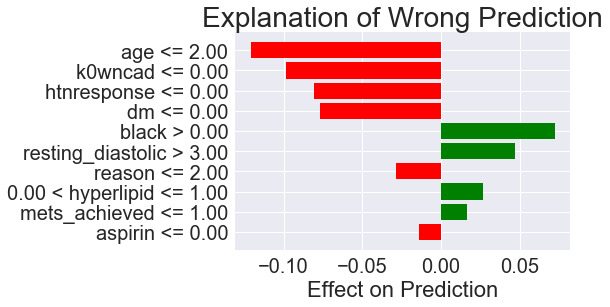

In [69]:
# Display the predicted and true value for the wrong example
print('Prediction: %d' % rtf.predict(wrong.reshape(1, -1)))
print('Actual Value: %d' % y_test[np.argmax(abs_diff)])

# Explanation for wrong prediction
wrong_exp = explainer.explain_instance(data_row = wrong, 
                                       predict_fn = rtf.predict_proba)

# Plot the prediction explaination
wrong_exp.as_pyplot_figure();
plt.title('Explanation of Wrong Prediction', size = 28);
plt.xlabel('Effect on Prediction', size = 22);

In [42]:
wrong
wrong_df = pd.Series(wrong, index=df_feats.columns )
wrong_df

age                    2.0
mets_achieved          1.0
resting_systolic       3.0
resting_diastolic      4.0
peak_diastolic         3.0
reason                 2.0
htnresponse            0.0
k0wncad                0.0
dm                     0.0
aspirin                0.0
hyperlipid             1.0
black                  1.0
percent_hr_achieved    3.0
dtype: float64

Prediction: 0
Actual Value: 0


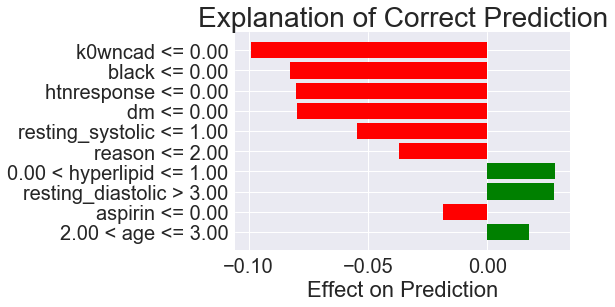

In [44]:
# Display the predicted and true value for the wrong instance
print('Prediction: %d' % rtf.predict(correct.reshape(1, -1)))
print('Actual Value: %d' % y_test[np.argmin(abs_diff)])

# Explanation for wrong prediction
correct_exp = explainer.explain_instance(correct, rtf.predict_proba)
correct_exp.as_pyplot_figure();
plt.title('Explanation of Correct Prediction', size = 28);
plt.xlabel('Effect on Prediction', size = 22);

In [45]:
correct_df = pd.Series(correct, index=df_feats.columns )


In [46]:
correct_df

age                    3.0
mets_achieved          1.0
resting_systolic       1.0
resting_diastolic      4.0
peak_diastolic         3.0
reason                 2.0
htnresponse            0.0
k0wncad                0.0
dm                     0.0
aspirin                0.0
hyperlipid             1.0
black                  0.0
percent_hr_achieved    3.0
dtype: float64